In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.stats import linregress
import scipy.stats as st
import json
import requests
import hvplot.pandas
from citipy import citipy
from pprint import pprint
from api_keys import US_Census_key
from api_keys import geoapify_key
from api_keys import weather_api_key

In [2]:
# Import data source 
# (Ref:Source: US Department of Transportation, Federal Highway Administration
# (https://www.fhwa.dot.gov/bipartisan-infrastructure-law/evs_5year_nevi_funding_by_state.cfm)

source_df = pd.read_csv("Resources/Original_National EV Infrastructure Funding by State.csv")

# Remove last row
clean_df = source_df.drop(index=[52])

# Replace "Dist. of Col." with "District of Columbia"
clean_df["State"] = clean_df["State"].str.replace("Dist. of Col.","District of Columbia")

# remove commas from numbers and convert to float
clean_df["Actual FY 2022"] = clean_df["Actual FY 2022"].str.replace(",","")
clean_df["Estimated FY 2023"] = clean_df["Estimated FY 2023"].str.replace(",","")
clean_df["Estimated FY 2024"] = clean_df["Estimated FY 2024"].str.replace(",","")
clean_df["Estimated FY 2025"] = clean_df["Estimated FY 2025"].str.replace(",","")
clean_df["Estimated FY 2026"] = clean_df["Estimated FY 2026"].str.replace(",","")
clean_df["Estimated Total"] = clean_df["Estimated Total"].str.replace(",","")

# Convert object values to float
clean_df["Actual FY 2022"] = clean_df["Actual FY 2022"].astype(int)
clean_df["Estimated FY 2023"] = clean_df["Estimated FY 2023"].astype(int)
clean_df["Estimated FY 2024"] = clean_df["Estimated FY 2024"].astype(int)
clean_df["Estimated FY 2025"] = clean_df["Estimated FY 2025"].astype(int)
clean_df["Estimated FY 2026"] = clean_df["Estimated FY 2026"].astype(int)
clean_df["Estimated Total"] = clean_df["Estimated Total"].astype(int)

# # print to csv file and screen file
clean_df.to_csv("Resources/Clean_National_EV_Infrastructure_Funding_Dataset.csv", index_label="Index")
clean_df.head()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_3577/3934399870.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_df["State"] = clean_df["State"].str.replace("Dist. of Col.","District of Columbia")


,State,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total
0,Alabama,11738801,16892267,16892384,16892399,16892434,79308285
1,Alaska,7758240,11164195,11164272,11164282,11164305,52415294
2,Arizona,11320762,16290704,16290816,16290830,16290864,76483976
3,Arkansas,8010850,11527704,11527783,11527793,11527817,54121947
4,California,56789406,81720595,81721161,81721230,81721400,383673792


In [3]:
# read merge datasource
merge_source = pd.read_csv("Resources/Pulled_EV_Final.csv")
merge_source.head()

,State,Registrations of EV 2019,Registrations of EV 2020,Registrations of EV 2021,Total EV,YOY(2020-2021)Growth Percentage,2019 - No. EV charge outlets,2020 - No. EV charge outlets,2021 - No. EV charge outlets,Total charging outlets,EV:Charger outlets,Average fuel price(current),Capital,ST,Lat,Lon
0,Alabama,722,2890.0,4750.0,8362.0,64.40%,506.0,596.0,680.0,1782.0,4.69,$3.08,Montgomery,AL,32.366966,-86.300648
1,Alaska,87,940.0,1290.0,2317.0,37.23%,34.0,45.0,94.0,173.0,13.39,$4.31,Juneau,AK,58.301950,-134.419734
2,Arizona,6637,28770.0,40740.0,76147.0,41.61%,1476.0,1778.0,2257.0,5511.0,13.82,$3.79,Phoenix,AZ,33.448437,-112.074141
3,Arkansas,370,1330.0,2390.0,4090.0,79.70%,290.0,350.0,453.0,1093.0,3.74,$3.09,Little Rock,AR,34.746507,-92.289627
4,California,100549,425300.0,563070.0,1088919.0,32.40%,27128.0,34622.0,41225.0,102975.0,10.57,$4.87,Sacramento,CA,38.581061,-121.493895


In [4]:
# keep required columns only "Lat", "Lon"
new_merge = merge_source[["State","Lat","Lon"]]
new_merge.head(3)


,State,Lat,Lon
0,Alabama,32.366966,-86.300648
1,Alaska,58.301950,-134.419734
2,Arizona,33.448437,-112.074141


In [5]:
# merge "Lat" and "Lon" to clean_df
funding_df = pd.merge(clean_df,new_merge,how="left",on="State")

# drop "nan" rows
clean_funding_df = funding_df.dropna(subset="Lat")

# set State as index
clean_funding_df1=clean_funding_df.set_index("State")
clean_funding_df1

# sort data set by Estimated total funding
Top_5_funding = clean_funding_df1.sort_values(by="Estimated Total", ascending=False)
Top_5_funding.head(5)


,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total,Lat,Lon
State,,,,,,,,
Texas,60356706,86853980,86854582,86854655,86854836,407774759,30.271129,-97.743700
California,56789406,81720595,81721161,81721230,81721400,383673792,38.581061,-121.493895
Florida,29315442,42185251,42185543,42185579,42185666,198057481,30.438083,-84.280933
New York,25971644,37373488,37373747,37373779,37373856,175466514,42.651167,-73.754968
Pennsylvania,25386631,36531648,36531901,36531932,36532008,171514120,40.266311,-76.886112


In [6]:
###GET POPULATION DATA FROM API TO ADD TO DATASET

In [7]:
# Base url

base_url = "https://api.census.gov/data/2021/pep/population?get=NAME,POP_2021&for=state&key=ddaeb0b8ea290503730d5e88987cf4f4829355a0"

# call data from API 
    
query = requests.get(base_url)
response = query.json()

Population_df = pd.DataFrame(response)
Population_df.columns = ["State","Est Population 2021", "State_No"]

# Remove first row
Population_df = Population_df.drop(index=[0])
Population_df

# read merge population data to main datasource
pop_funding_df = pd.merge(clean_funding_df1,Population_df,how="left",on="State")
final_funding_df = pop_funding_df.sort_values(by="Estimated Total", ascending=False)

# convert population from type "string" to type "int"
final_funding_df["Est Population 2021"] = final_funding_df["Est Population 2021"].astype(int)

# Remove first row, Alaska and Hawaii
final_funding_df = final_funding_df.drop(index=[1,10])
final_funding_df.head(5)


,State,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total,Lat,Lon,Est Population 2021,State_No
42,Texas,60356706,86853980,86854582,86854655,86854836,407774759,30.271129,-97.743700,29527941,48
4,California,56789406,81720595,81721161,81721230,81721400,383673792,38.581061,-121.493895,39237836,06
8,Florida,29315442,42185251,42185543,42185579,42185666,198057481,30.438083,-84.280933,21781128,12
31,New York,25971644,37373488,37373747,37373779,37373856,175466514,42.651167,-73.754968,19835913,36
37,Pennsylvania,25386631,36531648,36531901,36531932,36532008,171514120,40.266311,-76.886112,12964056,42


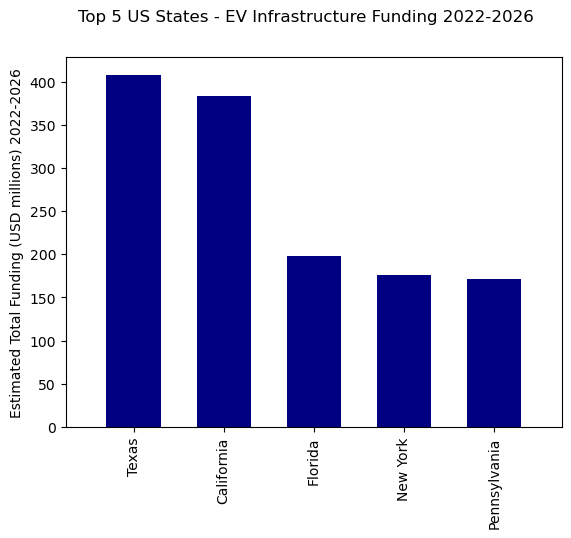

In [8]:
# prepare bar chart Top 5 states by Estimated Total Funding
# format Estimated Totals by dividing by 1 million


funding_by_state_chart = final_funding_df.head(5)

x_axis_State = funding_by_state_chart["State"]
y_axis_Funding = (funding_by_state_chart["Estimated Total"]/1_000_000)
x_axis = np.arange(0,len(x_axis_State))
tick_State=funding_by_state_chart["State"]
plt.xlim(-.75, len(x_axis)-.25)
plt.ylabel("Estimated Total Funding (USD millions) 2022-2026")
plt.bar(x_axis_State, y_axis_Funding, facecolor="navy", align="center",width=0.6)
plt.xticks(tick_State,x_axis_State, rotation=90)
plt.suptitle("Top 5 US States - EV Infrastructure Funding 2022-2026")

# export chart to file & display
plt.savefig("Resources/Chart_EV_Inf_Funding_by_State.png")
plt.show()


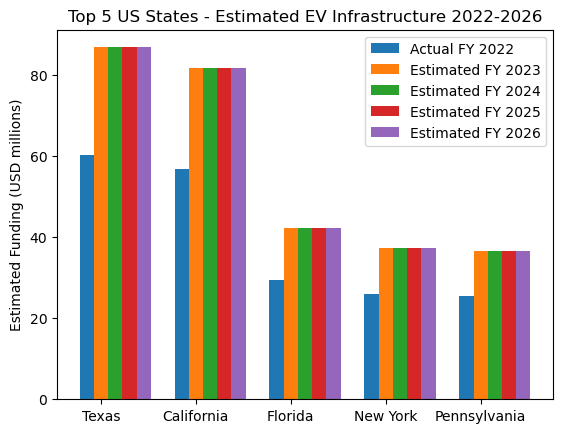

In [13]:
# Configure Chart spend by Top 5 over period 2022 to 2026
#plt.figure(figsize=(7, )) 

states = funding_by_state_chart["State"]
years = ["Actual FY 2022", "Estimated FY 2023", "Estimated FY 2024", "Estimated FY 2025", "Estimated FY 2026"]

bar_width = 0.15
index = range(len(states))

for year in years:
    funding = (funding_by_state_chart[f"{year}"]/1_000_000)
    plt.bar([pos + bar_width * years.index(year) for pos in index], funding, width=0.15, label=year)

#plt.xlim(0,5)
plt.ylabel("Estimated Funding (USD millions)")
plt.title("Top 5 US States - Estimated EV Infrastructure 2022-2026")
plt.xticks([pos + bar_width for pos in index], states)
plt.tight_layout
plt.legend()
plt.savefig("Resources/Chart_Top5_EV_Funding.png")
plt.show()

In [10]:
# Configure Chart spend per capita by State - hv plot
final_funding_df["Lat"]
final_funding_df["Lon"]

Spend_chart = final_funding_df.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    xlabel = " ",
    ylabel = " ",
    size = "Estimated Total",
    color = "State",
    title = "Estimated Total EV Infrastructure Funding 2022-2026 by State",
    hover_cols = ["Actual FY 2022", "Estimated FY 2023", "Estimated FY 2024", "Estimated FY 2025", "Estimated FY 2026"],
    scale = 0.0015)

# display and export chart
hvplot.save(Spend_chart, "Resources/Chart_Ttl_EV_Funding_hvplot_map.png")
Spend_chart

/Users/mireille.walton/anaconda3/envs/Bootcamp/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.17, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (State,Estimated Total,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026)

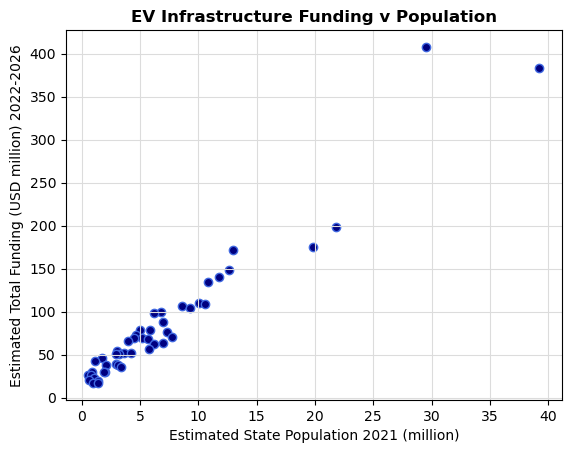

In [11]:
# create scatter chart for funding v population - format to millions
funding22_26 = (final_funding_df["Estimated Total"]/1_000_000)
est_pop21 = (final_funding_df["Est Population 2021"]/1_000_000)
plt.scatter(est_pop21, funding22_26, edgecolor = "royalblue", color = "navy", marker="o")
# Incorporate the other graph properties
plt.title("EV Infrastructure Funding v Population", weight = "bold")
plt.ylabel("Estimated Total Funding (USD million) 2022-2026")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")

# export chart to file & display
plt.savefig("Resources/Chart_EV_Inf_Pop.png")

# Show plot

plt.show()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_3577/1453517787.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis, LR_regress_val, "r-",color="red")


The r-value is: 0.97


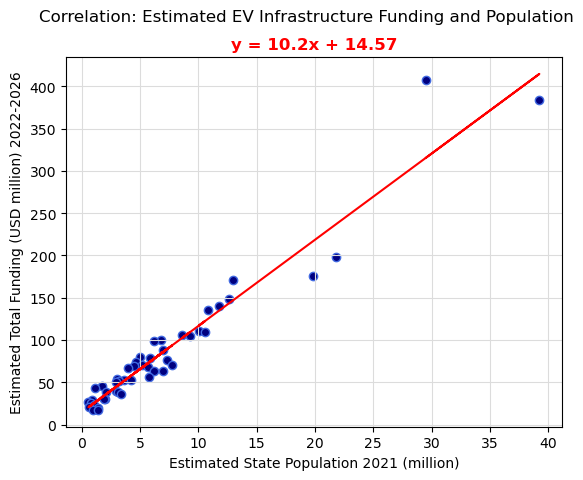

In [12]:
# investigate correlation between spend and State population

x_axis = est_pop21
y_axis = funding22_26


#def lin_regress(x_axis, y_axis, title, y_title):     
    
# calculate linear regression 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
LR_regress_val = x_axis * slope + intercept
LR_line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
R_val = st.pearsonr(x_axis, y_axis)
plt.scatter(x_axis, y_axis, edgecolor = "royalblue", color = "navy", marker="o")
R_val = st.pearsonr(x_axis, y_axis)
    
#plot linear regression 
plt.plot(x_axis, LR_regress_val, "r-",color="red")
print (f"The r-value is: {round(R_val[0], 2)}")
plt.suptitle("Correlation: Estimated EV Infrastructure Funding and Population"
 + "\n")
plt.title(LR_line_eq, weight='bold', color='red')
plt.ylabel("Estimated Total Funding (USD million) 2022-2026")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")

# export chart to file & display
plt.savefig("Resources/Chart_EV_Inf_Pop_LR.png")
plt.show()  